In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [1]:
!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
100% 86.8M/86.8M [00:00<00:00, 86.4MB/s]
100% 86.8M/86.8M [00:00<00:00, 95.9MB/s]


In [2]:
import zipfile
zip_ref = zipfile.ZipFile("/content/brain-tumor-classification-mri.zip",'r')
zip_ref.extractall("/content")
zip_ref.close()

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, BatchNormalization, Input, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
CHANNELS = 3
EPOCHS = 20
RANDOM_SEED = 32

In [5]:
X_train = []
y_train = []

labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Training
for i in labels:
    folderPath = os.path.join("/content/Training",i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        X_train.append(img)
        y_train.append(i)

#Tesing
for i in labels:
    folderPath = os.path.join("/content/Testing",i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


100%|██████████| 74/74 [00:00<00:00, 220.50it/s]


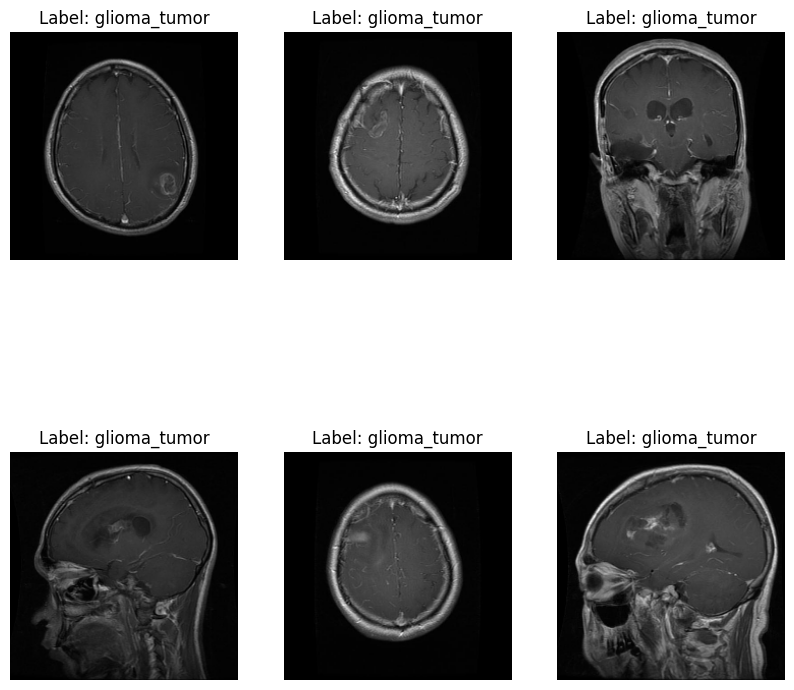

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(x_train, y_train, num_images=6):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(2, 3, i+1)
        plt.imshow(np.squeeze(x_train[i]), cmap='gray')  # Use 'gray' for grayscale images
        plt.title(f"Label: {y_train[i]}")
        plt.axis('off')  # Remove the axis

    plt.show()

plot_images(X_train, y_train)

In [7]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, y_train = shuffle(X_train, y_train, random_state = RANDOM_SEED)
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size = 0.2, random_state = RANDOM_SEED)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape # img, height, width, channel

((2611, 224, 224, 3), (653, 224, 224, 3), (2611,), (653,))

In [9]:
# One Hot Encording
y_train = tf.keras.utils.to_categorical([labels.index(i) for i in y_train])
y_test = tf.keras.utils.to_categorical([labels.index(i) for i in y_test])

In [10]:
# Transfer Learning (Round-1)
from tensorflow.keras.applications import InceptionResNetV2

base_model = InceptionResNetV2(
    include_top = False,
    weights = "imagenet",
    input_shape = (IMG_SIZE,IMG_SIZE,CHANNELS)
)

base_model.trainable = False

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [11]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_layer False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed_5b False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
ac

In [12]:
data_normalization = Sequential([
    tf.keras.layers.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

data_augmentation = Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip('horizontal')
])

In [13]:
model = Sequential([
    Input(shape = (IMG_SIZE,IMG_SIZE,CHANNELS)),
    data_normalization,
    data_augmentation,
    base_model,
    Dropout(0.5),
    Flatten(),
    Dropout(0.5),
    Dense(len(labels), activation = 'softmax') # output layer
])

In [14]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay= 5e-6),
              metrics = ['accuracy'])


In [15]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         153,604 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,490,340 (207.86 MB)

 Trainable params: 153,604 (600.02 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

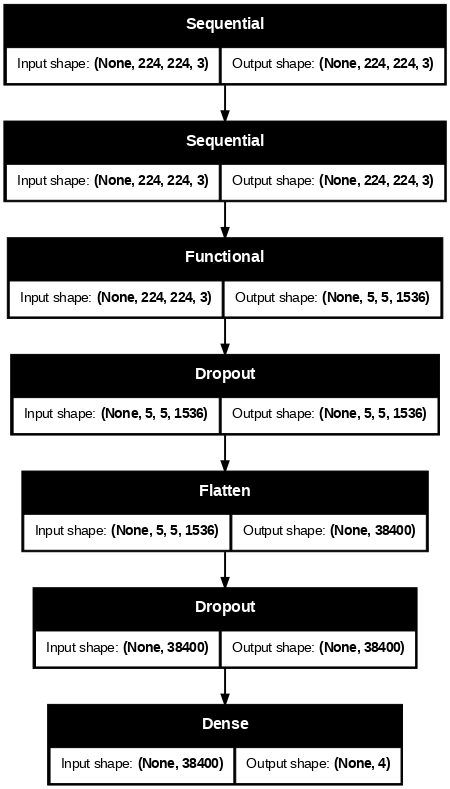

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, dpi = 70)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Metric to be monitored (e.g., val_loss, val_accuracy)
    factor=0.1,            # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=4,           # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,             # Print update messages to the console
    mode='min',            # Reduce learning rate when the quantity monitored has stopped decreasing
    min_lr=0.0000000001         # Lower bound on the learning rate
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,             # Print messages to the console
    mode='auto',            # Stop training when the quantity monitored has stopped decreasing
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity
)

# Set chackpoint path
checkpoint_path = "Checkpoint_model/checkpoints.weights.h5"
checkpoints_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                          save_weights_only = True,
                                                          save_best_only = True,
                                                          save_freq ="epoch", # Save every epoch
                                                          verbose = 1)

In [18]:
history1 = model.fit(X_train, y_train,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_split = 0.1,
                    callbacks = [reduce_lr, checkpoints_callback])

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.3235 - loss: 2.9607
Epoch 1: val_loss improved from inf to 1.28250, saving model to Checkpoint_model/checkpoints.weights.h5
37/37 ━━━━━━━━━━━━━━━━━━━━ 50s 732ms/step - accuracy: 0.3254 - loss: 2.9513 - val_accuracy: 0.5878 - val_loss: 1.2825 - learning_rate: 1.0000e-04
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.4580 - loss: 2.3560
Epoch 2: val_loss did not improve from 1.28250
37/37 ━━━━━━━━━━━━━━━━━━━━ 24s 425ms/step - accuracy: 0.4586 - loss: 2.3520 - val_accuracy: 0.5954 - val_loss: 1.3515 - learning_rate: 1.0000e-04
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.5271 - loss: 1.9384
Epoch 3: val_loss did not improve from 1.28250
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 434ms/step - accuracy: 0.5272 - loss: 1.9381 - val_accuracy: 0.6489 - val_loss: 1.3024 - learning_rate: 1.0000e-04
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5550 - loss: 1.8011
Epoch 4: val_loss im

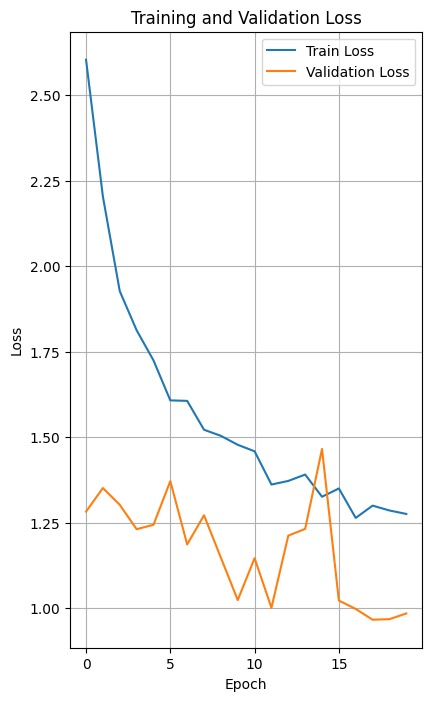

In [19]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

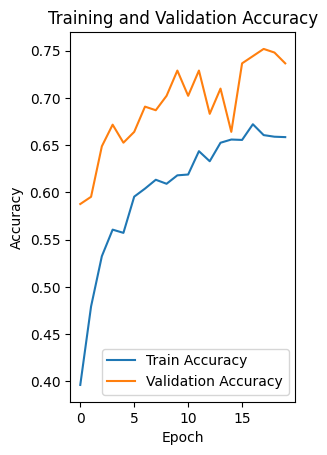

In [20]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Round 2
model.load_weights(checkpoint_path)
base_model.trainable = True

In [33]:
model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4, weight_decay= 5e-6),
              metrics = ['accuracy'])


In [34]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v2 (Functional)     │ (None, 5, 5, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 5, 5, 1536)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 38400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │         153,604 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,490,340 (207.86 MB)

 Trainable params: 54,429,796 (207.63 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [35]:
history2 = model.fit(X_train, y_train,
                    initial_epoch = EPOCHS,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS + 20,
                    validation_split = 0.1,
                    callbacks = [reduce_lr])

Epoch 21/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.5832 - loss: 1.1384 - val_accuracy: 0.5649 - val_loss: 2.6972 - learning_rate: 1.0000e-04
Epoch 22/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8184 - loss: 0.5183 - val_accuracy: 0.7290 - val_loss: 1.4872 - learning_rate: 1.0000e-04
Epoch 23/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.8478 - loss: 0.4342 - val_accuracy: 0.7710 - val_loss: 1.0294 - learning_rate: 1.0000e-04
Epoch 24/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8966 - loss: 0.2729 - val_accuracy: 0.7786 - val_loss: 1.1144 - learning_rate: 1.0000e-04
Epoch 25/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9226 - loss: 0.2105 - val_accuracy: 0.8397 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 26/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9475 - loss: 0.1503 - val_accuracy: 0.8550 - val_loss: 0.6815 - learning_rate: 1.0000e-04
Epoch 27/40
37/37 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.9495

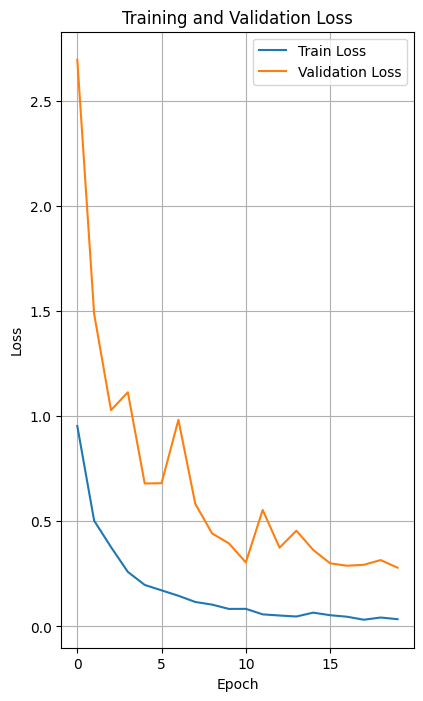

In [36]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

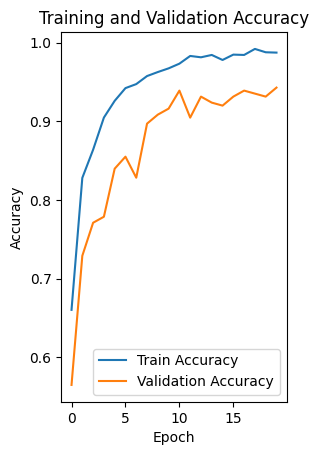

In [37]:
# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [38]:
from sklearn.metrics import classification_report,confusion_matrix

y_true = np.argmax(y_test, axis = 1)
y_pred = np.argmax(model.predict(X_test), axis = 1)

print(classification_report(y_true, y_pred))


21/21 ━━━━━━━━━━━━━━━━━━━━ 19s 539ms/step
              precision    recall  f1-score   support

           0       0.95      0.94      0.94       171
           1       0.97      0.93      0.95       196
           2       0.96      0.96      0.96       107
           3       0.94      0.99      0.97       179

    accuracy                           0.96       653
   macro avg       0.96      0.96      0.96       653
weighted avg       0.96      0.96      0.96       653



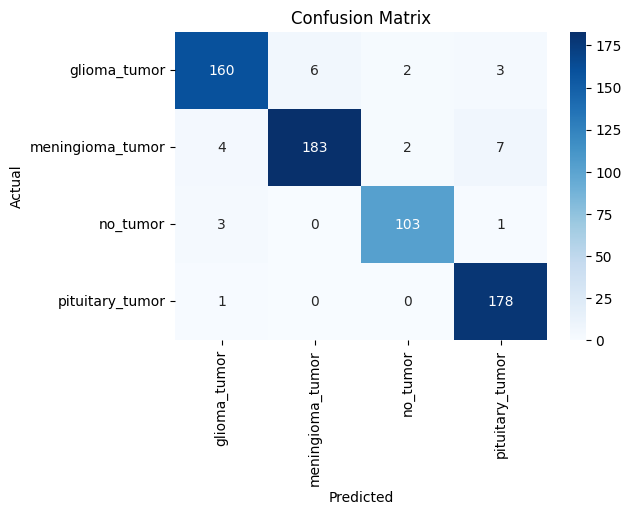

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels,
            yticklabels=labels)

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [40]:
def prediction(num=6, model=None, x_data=None, y_data=None, class_names=None):
    plt.figure(figsize=(10, 10))

    # Loop through the number of images you want to display
    for i in range(num):
        img = x_data[i]  # Get the image from x_train
        label = y_data[i]  # Get the true label from y_train

        # Display the image
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(img.astype('uint8'))
        actual_label = class_names[label]  # Get the actual class name

        # Predict the label for the current image
        img_batch = np.expand_dims(img, axis=0)  # Add batch dimension
        batch_prediction = model.predict(img_batch)  # Make prediction
        predicted_label = class_names[np.argmax(batch_prediction)]  # Get predicted class name
        confidence = round(100 * np.max(batch_prediction), 2)  # Get prediction confidence

        # Set the title with actual, predicted labels and confidence
        plt.title(f"Actual Label: {actual_label}\nPredicted Label: {predicted_label}\nConfidence: {confidence}%")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


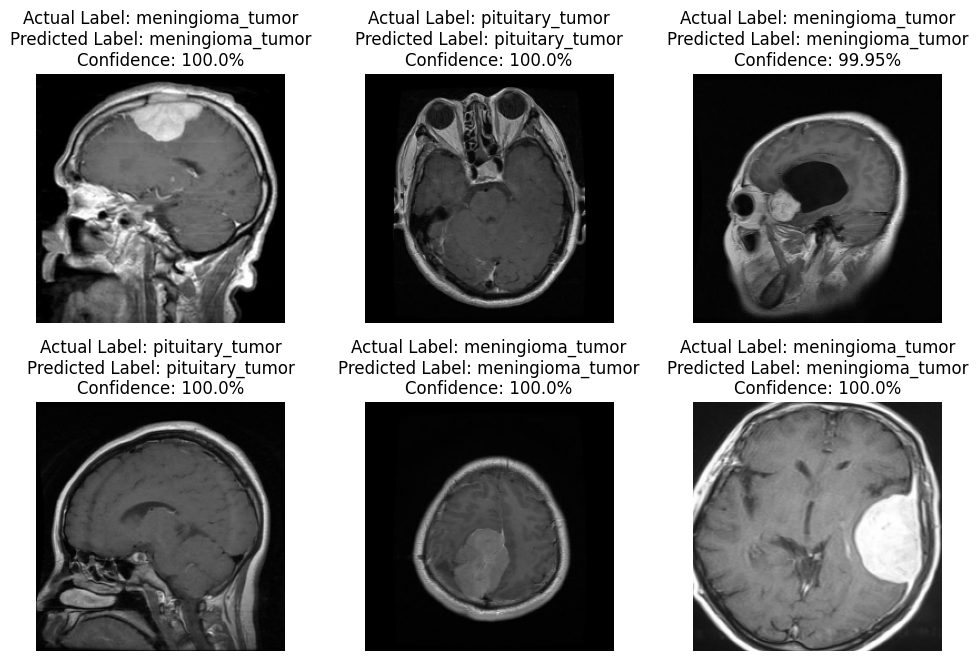

In [41]:
prediction(num=6, model=model, x_data=X_test, y_data=y_true, class_names=labels)

In [1]:
model.save("brain_tumor_model.keras")

NameError: name 'model' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')